**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

# Laboratório de Odometria

Neste laboratório iremos aplicar os nossos conhecimentos anteriores de visão estéreo, perpectiva de n pontos e de RANSAC em um problema de odometria.

In [24]:
# Se for executar localmente, tenha as seguintes bibliotecas instaladas
# !pip3 install opencv-contrib-python==4.6.0.66 Pillow==7.1.2 matplotlib==3.2.2 scipy==1.7.3 gdown==4.4.0

import cv2
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path
from scipy.spatial.transform import Rotation as R

plt.style.use('seaborn-darkgrid')

Se for executar local e quiser alterar o Path, pode alterar aqui sem problemas para a correção automática.

In [25]:
! [ ! -d "/content/odometria" ] && gdown -O /content/odometria.zip 1JanfRR4dJk6tfhpm_hTNRBkkNzoy7gpL && unzip /content/odometria.zip -d /content && rm /content/odometria.zip
root_path = Path("/content/odometria")

Vamos carregar parte das imagens e dos dados de tempos, de calibração e de referência.

In [26]:
N = 100
tempos = np.loadtxt(str(root_path/'tempos.txt'))
imgs_esq = [cv2.imread(str(p), cv2.IMREAD_ANYCOLOR) for p in sorted((root_path/'esquerda').glob('*.png'))[:N]]
proj_esq = np.loadtxt(str(root_path/'calib.txt'), dtype=np.float32)[0].reshape(3, 4)
imgs_dir = [cv2.imread(str(p), cv2.IMREAD_ANYCOLOR) for p in sorted((root_path/'direita').glob('*.png'))[:N]]
proj_dir = np.loadtxt(str(root_path/'calib.txt'), dtype=np.float32)[1].reshape(3, 4)
refs = np.loadtxt(str(root_path/'referencia.txt'), dtype=np.float32).reshape(-1, 3, 4)

## Operações de Odometria

Para o caso da odometria monocular, é necessário um parâmetro de escala para conseguir estabelecer a distância percorrida (nas unidades de comprimento) entre dois quadros. Esse fator de escala pode ser oriundo de sensores inerciais ou de ainda algum outro sensor associade à unidade de comprimento (como um velocímetro). Dessa forma, vamos acabar derivando a velocidade a partir dos dados de posição de referência (que foram obtidas de fusão de sensores inerciais e de posição).

Implemente a função abaixo que deriva a velocidade a partir das matrizes de pose. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Use apenas indexação de matrizes do numpy e também `np.linalg.norm` aplicado apenas em um eixo `axis` específico.
</p>
</details>

In [27]:
def calcula_velocidade(posicoes, tempos):
    """
    Calcula a velocidade a partir de matrizes de pose e de um vetor de tempo por meio de diferenças finitas
    :param posicoes: Matrizes de pose (n, 3, 4) em metros [R_mat | T_vec]
    :param delta_t: Vetor do tempo (n, ) associada a cada posição em segundos, crescente
    Retorna vetor de velocidades lineares em m/s calculada por diferenças finitas progressivas (diferença da próxima
    posição para a atual).
    """
    velocidades = []
    for i in range(posicoes.shape[0]-1):
      velocidades.append(np.linalg.norm(posicoes[i+1,:,3]-posicoes[i,:,3])/(tempos[i+1]-tempos[i]))
    return velocidades

In [28]:
velos = calcula_velocidade(refs[:11], tempos[:11])
assert np.linalg.norm(velos - np.array([1.22559295, 1.37714263, 1.58089024, 1.71854421, 1.85536711,
       1.99962678, 2.11304293, 2.24617   , 2.38809648, 2.5471701 ])) < 1e-4
velocidades = calcula_velocidade(refs[:len(tempos)], tempos)

Dados deste laboratório foram extraídos do [KITTI](https://www.cvlibs.net/datasets/kitti/) (Karlsruhe Institute of Technology and Toyota Technological Institute) e servem como benchmark de algoritmos de localização para carros autônomos (apesar de que para um dataset de mais de 10 anos, já tivemos uma significativa evolução dos sensores).

Neste laboratório iremos utilizar apenas as câmeras mono da esquerda (Cam 0) e da direita (Cam 1), além dos dados de calibração e de referência (para comparação). Perceba que o referencial da câmera da esquerda está próximo ao centro de massa o do carro (a menos da altura) e será utilizado como o sistema de coordenadas do carro.

Perceba que a direção do Z é a frente, a direção do X é da lateral direita do carro e a direção do Y é para baixo.

![Posição das câmeras no carro](https://www.cvlibs.net/datasets/kitti/images/setup_top_view.png)

As imagens estéreo já foram retificadas (`R_mat = np.eye(3)`) e des-distorcidas, de tal forma que a há uma única componente de translação horizontal entre as câmeras. Encontre esse vetor a partir da matriz de projeção (a matriz que leva pontos no espaço 3d para pontos homogêneos em pixels 2d, resultado de `mtx @ [R_mat | t_vec]`) e também a matrix intrínseca `mtx`. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Use apenas indexação de matrizes do numpy.
</p>
</details>

In [53]:
def matriz_projecao_para_mtx_T(matriz_projecao):
    """
    Decompõe a matrix de projeção na matriz intríseca e no vetor de translação, considerando um sistema de câmeras
    já retificadas horizontalmente (não há rotação e apenas translação horizontal)
    :param matriz_projecao: matriz de projeção 3x4 resultado de mtx @ [R_mat | t_vec]
    Retorna a matriz_intrinseca mtx 3x3 em pixels e o vetor de translação t_vec 3x1 em metros.
    Na resposta não é para chamar nenhuma função do OpenCV, é para calcular manualmente
    """
    vetor_translacao = []
    matriz_intrinseca = []
    for i in range(matriz_projecao.shape[0]):
      matriz_intrinseca.append(matriz_projecao[i,:3])
      vetor_translacao.append([np.array(matriz_projecao[i,3]/matriz_projecao[0,0])])
    return matriz_intrinseca, vetor_translacao

In [54]:
P = np.array([[50, 0, 100, 100],[0, 50, 100, 0],[0, 0, 1, 0]])
mtx, t_vec = matriz_projecao_para_mtx_T(P)
assert np.all(mtx == np.array([[50, 0, 100], [0, 50, 100], [0, 0, 1]]))
assert np.all(t_vec == np.array([[2],[0],[0]]))

mtx_esq, t_esq = matriz_projecao_para_mtx_T(proj_esq)
mtx_dir, t_dir = matriz_projecao_para_mtx_T(proj_dir)

Outra operação essencial de odometria é reconstruir a trajetória absoluta a partir dos vetores de deslocamento e das matrizes de rotação relativas extraídas de cada frame. Observe que é nessa operação que os erros se propagam e aumentam com o tempo (drifting) uma vez que se realiza a soma (vetorial) dos deslocamentos.

Assim, implemente a função abaixo que realiza essa transformação de coordenadas encadeada para obter a trajetória com relação à pose inicial. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Basta usar multiplicação de matrizes no numpy, o operador `a @ b` que é equivalente a `np.matmul(a, b)`. Não vai me confundir a rotação (pensando que é para calcular a inversa) e a translação (pensando que é para subtrair), as matrizes e os vetores já estão representados como deslocamentos (que levam do atual para o próximo).
</p>
</details>

In [55]:
def reconstroi_trajetoria(lista_matrizes_rotacao, lista_vetores_deslocamento):
    """
    Reconstroi a trajetória a partir da origem (a ser incluída como primeiro ponto da saída).
    :param lista_matrizes_rotacao: lista de matrizes de rotação 3x3 que descreve a rotação da próxima pose com 
                                   relação à atual
    :param lista_matrizes_rotacao: lista de vetores de deslocamento 3x1 que descreve o deslocamento da próxima 
                                   pose com relação à atual
    Retorna a lista de rotações e translações  com relação à origem.
    """
    lista_rotacao_absoluta = []
    lista_rotacao_absoluta.append(np.eye(3))
    lista_posicao_absoluta = []
    lista_posicao_absoluta.append(np.array([[0],[0],[0]]))
    for i in range(len(lista_matrizes_rotacao)):
      lista_rotacao_absoluta.append(np.matmul(lista_rotacao_absoluta[i],lista_matrizes_rotacao[i]))
      lista_posicao_absoluta.append(np.matmul(lista_rotacao_absoluta[i],lista_vetores_deslocamento[i])+lista_posicao_absoluta[i])
    return lista_rotacao_absoluta, lista_posicao_absoluta

In [56]:
rmats, tvecs = reconstroi_trajetoria([R.from_euler('XYZ',[0,np.pi/4,0]).as_matrix()]*8, [np.array([[0],[0],[1]])]*8)
assert np.linalg.norm(rmats[0] - np.eye(3)) < 1e-6
assert np.linalg.norm(tvecs[0] - np.zeros(3)) < 1e-6
assert np.linalg.norm(rmats[8] - np.eye(3)) < 1e-6
assert np.linalg.norm(tvecs[8] - np.zeros(3)) < 1e-6

Veja a trajetória de exemplo abaixo que se desloca 1 metro para a frente e vira 45º para a direita a cada passo:

OBS: Seguindo a convenção do sistema de coordenadas do carro, plotamos os eixos X e Z

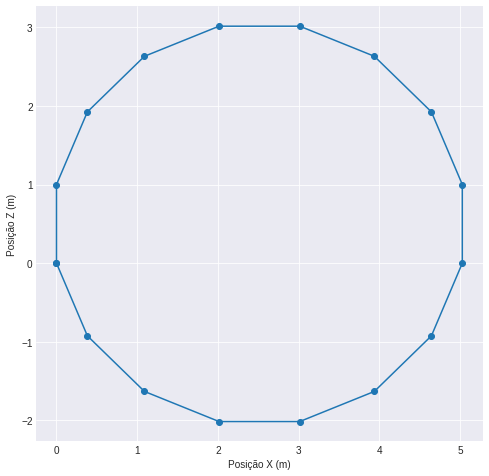

In [57]:
n = 16
rmats,tvecs=reconstroi_trajetoria([R.from_euler('XYZ',[0,2*np.pi/n,0]).as_matrix()]*n, [np.array([[0],[0],[1]])]*n)
plt.figure(figsize=(8, 8))
plt.plot([p[0,0] for p in tvecs], [p[2,0] for p in tvecs], 'o-')
plt.xlabel('Posição X (m)')
plt.ylabel('Posição Z (m)')
plt.show()

## Odometria Monocular (com dados externos de velocidade)

O passo mais simples da odometria é utilizar imagens apenas de uma câmera para conseguir estimar a pose relativa entre dois frames. O problema é que não é possível determinar o fator de escala entre as imagens, dessa forma é necessário conhecer ou a escala (distância) de pelo menos um ponto ou ainda a escala (distância) entre as duas poses, que no caso pode ser facilmente obtida conhecendo-se a velocidade.

O primeiro passo da odometria é calcular o deslocamento 2d entre os pontos projetados na imagem. Podemos fazer isso de forma esparsa, com um detector de features (que detecta pontos salientes na imagem com seus descritores) e um correlacionador dessas features, que tenta 

Outra alternativa que veremos a seguir é justamente calcular o fluxo óptico entre as duas imagens, selecionando apenas os pontos de maior distinção.

In [58]:
detector = cv2.ORB_create(nfeatures=4500, scaleFactor=1.19)
relacionador = cv2.FlannBasedMatcher(indexParams={
    'algorithm':6, 'table_number':6, 'key_size':12, 'multi_probe_level':1}, searchParams={'checks': 50})

def pegar_pontos_iguais(img1, img2):
    """
    Recebe duas imagens e retorna as coords. de pontos correspondentes nx2
    """
    pontos1, descritores1 = detector.detectAndCompute(img1, None)
    pontos2, descritores2 = detector.detectAndCompute(img2, None)
    relacoes = relacionador.knnMatch(descritores1, descritores2, k=2)
    relacoes_fortes = [r1 for r1, r2 in relacoes if r1.distance < 0.7 * r2.distance]
    pts1 = np.array([pontos1[r.queryIdx].pt for r in relacoes_fortes], dtype=np.float32)
    pts2 = np.array([pontos2[r.trainIdx].pt for r in relacoes_fortes], dtype=np.float32)
    return pts1, pts2

Veja abaixo, por exemplo, a relação encontrada para os pontos entre duas imagens consecutivas:

Na realidade peguei uma imagem 3 quadros passados para ficar maiores os deslocamentos e também a rotação maior (para o corretor automático).

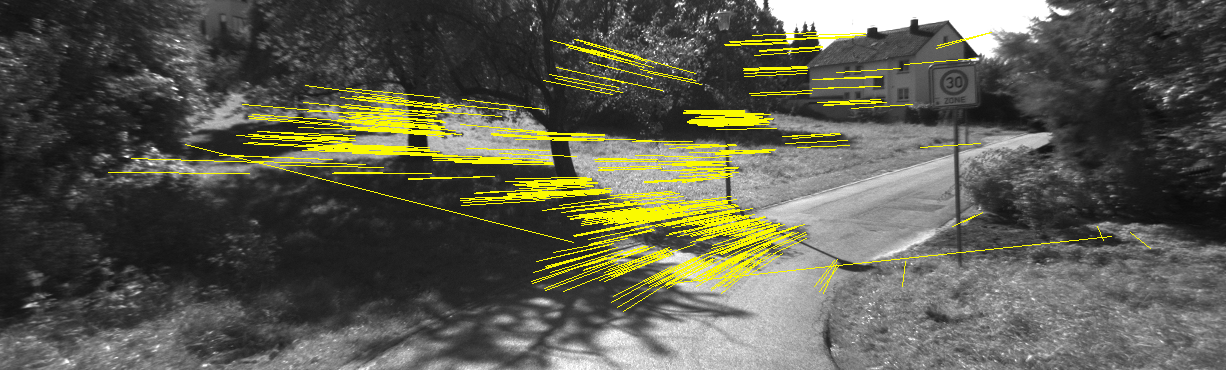

In [59]:
pts_fut, pts = pegar_pontos_iguais(imgs_esq[47], imgs_esq[44])
img = np.repeat(imgs_esq[44][:, :, None], 3, axis=-1)
for pfut, p in zip(pts_fut, pts): # Desenha uma linha ligando os pares de pontos
    cv2.line(img, np.uint(p), np.uint(pfut), (250, 250, 0))
PIL.Image.fromarray(img)

Como o primeiro passo em geral resulta em uma grande quantidade de outlier, no segundo passo de encontrar a matriz essencial (que é posteriormente decomposta na matriz de rotação e translação), utiliza-se o RANSAC.

Relembrando que a matriz essencial ($\mathbf  {E}$) é o resultado do produto entre a matriz de rotação e a matriz de translação do produto vetorial $\mathbf  {E}=\mathbf  {R}\,[\mathbf  {t}]_{\times }$, onde $[\mathbf  {t}]_{\times }$ é a representação matricial da operação de produto vetorial:

$\mathbf {a} \times \mathbf {b} =[\mathbf {a} ]_{\times }\mathbf {b} ={\begin{bmatrix}\,0&\!-a_{3}&\,\,a_{2}\\,\,a_{3}&0&\!-a_{1}\\-a_{2}&\,\,a_{1}&\,0\end{bmatrix}}{\begin{bmatrix}b_{1}\\b_{2}\\b_{3}\end{bmatrix}}$

Para estimar a matriz essencial são necessário pelo menos 8 pares de pontos (no mínimo é 7 mas 8 é mais estável). Dessa forma o RANSAC fará amostras aleatórias de 8 pares de pontos e calculará a matriz essencial (o modelo). As distâncias dos pontos até as suas linhas epipolares são utilizadas como limiar para determinar se um ponto é ou não outlier para o modelo. Assim, escolhe-se o modelo com a maior quantidade de inliers.

Implemente a função abaixo que simplesmente chama a função `cv2.recoverPose` do OpenCV. (1 ponto)

In [83]:
def estima_rotacao_translacao(pts_futuro, pts_atual, mtx, metodo=cv2.USAC_ACCURATE, confianca=0.9999, dist=2):
    """
    Utiliza a função cv2.recoverPose que calcula a matriz essencial (e faz a sua decomposição na rotação e 
    translação) a partir dos pares de pontos. Utilize o método de cv2.USAC_ACCURATE, que é mais eficiente do
    que o velho RANSAC.
    :param pts_futuro: Matriz de pontos 2d nx2 na imagem futura
    :param pts_atual: Matriz de pontos 2d nx2 relacionados ao pts_futuro
    :param mtx: Matriz intrínseca da câmera, a imagem já foi des-distorcida
    :param confianca: Probabilidade de acerto do RANSAC
    :param dist: Limiar de distância entre o ponto e o modelo (linha epipolar) para considerar outlier
    Retorna a matriz de rotação e o vetor de translação normalizado, além da máscara dos inliers.
    """
    mtx = np.matrix(mtx)
    retval,E,matriz_rotacao,direcao_translacao,inliers=cv2.recoverPose(pts_futuro,pts_atual,mtx,None,mtx,None,method=metodo,prob=confianca,threshold=dist)
    return matriz_rotacao, direcao_translacao, inliers

In [84]:
mtx_esq, t_esq = matriz_projecao_para_mtx_T(proj_esq)
pts_fut, pts = pegar_pontos_iguais(imgs_esq[47], imgs_esq[44])
rmat, tvec, mask = estima_rotacao_translacao(pts_fut, pts, mtx_esq)
assert np.linalg.norm(rmat - np.array(
       [[ 0.99590877,  0.00659954,  0.09012309],
        [-0.00645422,  0.99997736, -0.00190382],
        [-0.09013362,  0.00131436,  0.99592881]])) < 1e-2
assert np.linalg.norm(tvec - np.array(
       [[ 0.05638571],
        [-0.0194907 ],
        [ 0.9982188 ]])) < 1e-1

Veja como ficam os outliers (em vermelho)

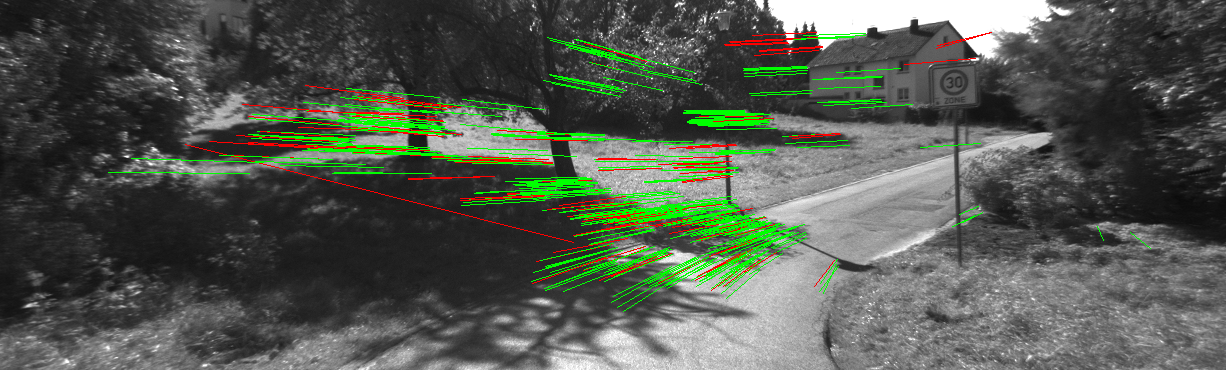

In [85]:
img = np.repeat(imgs_esq[44][:, :, None], 3, axis=-1)
for pfut, p, inlier in zip(pts_fut, pts, mask.ravel()): # Desenha uma linha ligando os pares de pontos
    cor = (255, 0, 0)
    if inlier:
        cor = (0, 255, 0)
    cv2.line(img, np.int32(p), np.int32(pfut), cor)
PIL.Image.fromarray(img)

Agora vamos corrigir a escala do vetor de translação, dado a nossa velocidade estimada e um intervado de tempo. (1 ponto)

In [98]:
def corrige_escala(vetor_translacao, velocidade, delta_t):
    """
    Aplica a escala no vetor deslocamento, usando a aproximação de primeira ordem (linear).
    :param vetor_translacao: Vetor de translação/deslocamento 3x1
    :param velocidade: Escalar da velocidade (m/s)
    :param delta_t: Escalar do intervalo de tempo considerado (segundos)
    Retorna o vetor de translação dimensionalizado (m) pela velocidade
    """
    d = velocidade*delta_t
    vetor_dimensionalizado = d*vetor_translacao
    return vetor_dimensionalizado

In [99]:
assert np.linalg.norm(corrige_escala(np.array([[3],[2],[8]]), 1, 1) - np.array([[3],[2],[8]])) < 1e-8

Finalmente juntamos todas as funções que implementamos até agora. Implemente a função abaixo. (3 pontos)

In [ ]:
def odometria_mono(imgs, mtx, velocidades, tempos):
    """
    Recebe uma sequência de imagens tiradas de uma mesma câmera, e reconstroe a trajetória percorrida.
    Utilize a imagem imediatamente subsequente para estimar a pose relativa de cada imagem da sequência.
    :param imgs: lista de imagens de escala de cinza
    :param mtx: matriz intrínseca da câmera, a imagem já está des-distorcida
    :param velocidades: vetor de velocidades (m/s)
    :param tempos: vetor de tempos (s)
    Usa a função pegar_pontos_iguais que recebe duas imagens e retorna duas matrizes de pontos2d
    Retorna a trajetória percorrida, reconstruída tomando-se o primeiro quadro como a origem
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return np.array(lista_rotacao_absoluta), np.array(lista_posicao_absoluta)

In [ ]:
rotacoes, posicoes = odometria_mono(imgs_esq[:70], mtx_esq, velocidades[:69], tempos[:70])
assert np.linalg.norm(rotacoes[0] - np.eye(3)) < 1e-6
assert np.linalg.norm(posicoes[0] - np.zeros(3)) < 1e-6
assert np.linalg.norm(rotacoes[-1] - np.array(
      [[-0.5063042 ,  0.04474437,  0.8611933 ],
       [ 0.03299499,  0.9989269 , -0.03250242],
       [-0.8617235 ,  0.01195895, -0.5072372 ]])) < 5e-2
assert np.linalg.norm(posicoes[-1] - np.array(
      [[38.33941  ],
       [ 0.7189929],
       [ 2.756405 ]])) < 3.5

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(posicoes[:, 0, 0], posicoes[:, 2, 0], 'b-o', label='Odometria')
plt.plot(refs[:len(posicoes), 0, 3], refs[:len(posicoes), 2, 3], 'g-x', label='Referência')
plt.legend()
plt.xlabel('Distância em X (m)')
plt.ylabel('Distância em Y (m)')
plt.axis('equal')
plt.show()

Podemos refazer todo o processo acima, substuindo a função que faz o rastreio 2d, de um caso de features detector por fluxo optico:

In [ ]:
def pegar_pontos_fluxo_optico(img_fut, img):
    p = cv2.goodFeaturesToTrack(img, maxCorners=3200, qualityLevel=0.012, minDistance=8, blockSize=5)
    pfut, status, err = cv2.calcOpticalFlowPyrLK(img, img_fut, p, None, winSize=(15, 15))
    valid = status.ravel().astype(np.bool8)
    return pfut.reshape(-1, 2)[valid], p.reshape(-1, 2)[valid]

In [ ]:
pts_fut, pts = pegar_pontos_fluxo_optico(imgs_esq[47], imgs_esq[46])
img = np.repeat(imgs_esq[46][:, :, None], 3, axis=-1)
for pfut, p in zip(pts_fut, pts): # Desenha uma linha ligando os pares de pontos
    cv2.line(img, np.int32(p), np.int32(pfut), (250, 250, 0))
print(len(pts))
PIL.Image.fromarray(img)

Agora reimplemente a função acima, mas usando a função `pegar_pontos_fluxo_optico` para estabelecer o vínculo 2d. Perceba o que acontece com o resultado. (1 ponto)

In [ ]:
def odometria_mono_LK(imgs, mtx, velocidades, tempos):
    """
    Recebe uma sequência de imagens tiradas de uma mesma câmera, e reconstroe a trajetória percorrida.
    Utilize a imagem imediatamente subsequente para estimar a pose relativa de cada imagem da sequência.
    :param imgs: lista de imagens de escala de cinza
    :param mtx: matriz intrínseca da câmera, a imagem já está des-distorcida
    :param velocidades: vetor de velocidades (m/s)
    :param tempos: vetor de tempos (s)
    Usa a função pegar_pontos_fluxo_optico que recebe duas imagens e retorna duas matrizes de pontos2d
    Retorna a trajetória percorrida, reconstruída tomando-se o primeiro quadro como a origem
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return np.array(lista_rotacao_absoluta), np.array(lista_posicao_absoluta)

In [ ]:
rotacoes, posicoes = odometria_mono_LK(imgs_esq[:70], mtx_esq, velocidades[:69], tempos[:70])
assert np.linalg.norm(rotacoes[0] - np.eye(3)) < 1e-6
assert np.linalg.norm(posicoes[0] - np.zeros(3)) < 1e-6
assert np.linalg.norm(rotacoes[-1] - np.array(
      [[-0.5063042 ,  0.04474437,  0.8611933 ],
       [ 0.03299499,  0.9989269 , -0.03250242],
       [-0.8617235 ,  0.01195895, -0.5072372 ]])) < 4e-2
assert np.linalg.norm(posicoes[-1] - np.array(
      [[38.33941  ],
       [ 0.7189929],
       [ 2.756405 ]])) < 1

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(posicoes[:, 0, 0], posicoes[:, 2, 0], 'b-o', label='Odometria')
plt.plot(refs[:len(posicoes), 0, 3], refs[:len(posicoes), 2, 3], 'g-x', label='Referência')
plt.legend()
plt.xlabel('Distância em X (m)')
plt.ylabel('Distância em Y (m)')
plt.axis('equal')
plt.show()

## Odometria Estéreo

Agora não dependemos mais da informação de velocidade externa para estabelecer a realação de escala, uma vez que conhecemos as distâncias entre as câmeras (em metros), conseguimos determinar o nosso deslocamento (em metros), a partir da triangulação de pontos que sejam identificados 

In [ ]:
def pegar_pontos_iguais_quad(img_esq, img_esq_fut, img_dir, img_dir_fut):
    """
    Recebe quatro imagens e retorna uma lista com as coords. de pontos correspondentes nx2 por feature matching
    """
    imgs = [img_esq, img_esq_fut, img_dir, img_dir_fut]
    pts_des = [detector.detectAndCompute(img, None) for img in imgs] # Detecta e descreve bons pontos
    # Relaciona os pontos com a primeira imagem
    rels = [relacionador.knnMatch(des, pts_des[0][1], k=2) for pts, des in pts_des[1:]]
    rels_filtrados = [[r1 for r1, r2 in rel if r1.distance < 0.7 * r2.distance] for rel in rels]
    rels_t = [[r.trainIdx for r in rel] for rel in rels_filtrados]
    rels_q = [[r.queryIdx for r in rel] for rel in rels_filtrados]
    img0_idxs = [set(rt) for rt in rels_t]
    idxs_comuns = img0_idxs[0].intersection(*img0_idxs[1:])
    rels_intersect = [[rq[rt.index(i)] for i in idxs_comuns] for rt, rq in zip(rels_t, rels_q)]
    pts0 = np.array([pts_des[0][0][idx].pt for idx in idxs_comuns], dtype=np.float32)
    pts = [np.array([pts[idx].pt for idx in rels_intersect[i]], dtype=np.float32)
            for i, (pts , des) in enumerate(pts_des[1:])]
    return [pts0] + pts

def pegar_pontos_fluxo_optico_quad(img_esq, img_esq_fut, img_dir, img_dir_fut):
    """
    Recebe quatro imagens e retorna uma lista com as coords. de pontos correspondentes nx2 por Lukas-Kanade
    """
    p0 = cv2.goodFeaturesToTrack(img_esq, maxCorners=3200, qualityLevel=0.012, minDistance=8, blockSize=5)
    p1, status1, err = cv2.calcOpticalFlowPyrLK(img_esq, img_esq_fut, p0, None, winSize=(15, 15))
    p2, status2, err = cv2.calcOpticalFlowPyrLK(img_esq, img_dir, p0, None, winSize=(15, 15))
    p3, status3, err = cv2.calcOpticalFlowPyrLK(img_dir, img_dir_fut, p2, None, winSize=(15, 15))
    # Verifica se o vínculo estéreo está satisfeito (linhas epipolares horizontais)
    stereo1 = (np.abs(p0 - p2).reshape(-1, 2)[:, 1] < 1.2) & ((p0 - p2).reshape(-1, 2)[:, 0] > 0)
    stereo2 = (np.abs(p1 - p3).reshape(-1, 2)[:, 1] < 1.2) & ((p1 - p3).reshape(-1, 2)[:, 0] > 0)
    valid = ((status1 & status2 & status3).ravel() & stereo1 & stereo2).astype(np.bool8)
    return [p.reshape(-1, 2)[valid] for p in [p0, p1, p2, p3]]

Observe como fica o fluxo óptico de quadros de um mesmo instante entre câmeras retificadas

In [ ]:
p1, p2, p3, p4 = pegar_pontos_fluxo_optico_quad(imgs_esq[40], imgs_esq[41], imgs_dir[40], imgs_dir[41])
img = np.repeat(imgs_esq[40][:, :, None], 3, axis=-1)
for pfut, p in zip(p3, p1): # Desenha uma linha ligando os pares de pontos
    cv2.line(img, np.int32(np.round(p)), np.int32(np.round(pfut)), (250, 250, 0))
print(len(p1))
PIL.Image.fromarray(img)

In [ ]:
img = np.repeat(imgs_dir[40][:, :, None], 3, axis=-1)
for pfut, p in zip(p4, p3): # Desenha uma linha ligando os pares de pontos
    cv2.line(img, np.int32(np.round(p)), np.int32(np.round(pfut)), (250, 250, 0))
PIL.Image.fromarray(img)

Uma das formas mais simples de agregar dados de múltiplas câmeras é fazer a média das rotações e dos deslocamentos que cada uma percebe. O ideal seria realizar a otimização conjunta de ambas as câmeras, mas como o OpenCV não tem uma função que faça um Bundle Adjustment, vamos quebrar em várias etapas e juntar os resultados como a média das câmreras.

Mas primeiro é necessário corrigir os deslocamentos, uma vez que, a translação que a câmera da direita percebe (fora do "CG") é diferente translação que a câmera da esquerda percebe (que está no CG). Vamos levar todos esses deslocamentos para o CG, a fim de padronizar.

Implemente a função abaixo que realiza essa correção. (1 ponto)

In [ ]:
def compensa_cg(tvec, rotm, dist_cg):
    """
    Compensa a diferença de translação que a câmera da direita tem com relação à câmera da esquerda que está na
    origem ("CG") do carro
    :param tvec: Vetor de translação 3x1 do movimento observada pela câmera da direita
    :param rotm: Matriz de rotação 3x3 do movimento (observada por ambas as câmeras, 
                                    a rotação é a mesma para qualquer ponto no corpo)
    :dist_cg: Vetor de translação do CG (cam esquerda) até a câmera da direita
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return tvec_compensado_cg

In [ ]:
assert np.linalg.norm(np.zeros((3,1)) - 
    compensa_cg(np.array([[-1], [0], [-1]]), R.from_euler('XYZ',[0,-np.pi/2,0]).as_matrix(), 
                np.array([[1],[0],[0]]))
                     ) < 1e-6
assert np.linalg.norm(np.array([[1-np.sqrt(2)/2],[0],[np.sqrt(2)/2]]) - 
    compensa_cg(np.array([[0], [0], [0]]), R.from_euler('XYZ',[0,-np.pi/4,0]).as_matrix(), 
                np.array([[1],[0],[0]]))
                     ) < 1e-6

Essas otimizações seriam melhores se fossem feitas em conjunto para o caso estéreo, mas como o OpenCV não tem um Bundle Adjustment, iniciamos estimando a rotação e translação monocular (para cada câmera em separado)

In [ ]:
r1, t1, m1 = estima_rotacao_translacao(p2, p1, mtx_esq)
r2, t2, m2 = estima_rotacao_translacao(p4, p3, mtx_dir)
inliers = (m1 & m2).ravel().astype(np.bool8)
if np.sum(inliers) < 10: # Deixar tudo na mão do RANSAC do PnP
    inliers = np.ones((len(m1),), dtype=np.bool8)
media_rots = R.from_matrix([r1, r2]).mean().as_matrix()

Com base na triangulação dos pontos que tenham sido corretamente identificado nas 4 imagens, vamos uma triangulação para os pontos no passado e outra para os pontos do futuro. Daí já poderíamos identificar o deslocamento e a rotação entre essas nuvens de pontos, mas seria bom usar um RANSAC pois podem ter outliers.

In [ ]:
pts4d = cv2.triangulatePoints(proj_esq, proj_dir, p1[inliers].T, p3[inliers].T)
pts3d = pts4d[:3, :] / pts4d[3:, :]
pts4d_fut = cv2.triangulatePoints(proj_esq, proj_dir, p2[inliers].T, p4[inliers].T)
pts3d_fut = pts4d_fut[:3, :] / pts4d_fut[3:, :]

Como já tem um RANSAC implementado no PnP, fica mais fácil usá-lo aqui. Assim, podemos aplicar o PnP de várias formas, com a geometria triangulada no passado ou no futuro, na câmera direita ou esquerda. Lembrando que se aplicar no passado/futuro será a transformação inversa obtida (ao invés de caminhar para frente estará caminhando para trás).

In [ ]:
ok_esq, rvec_esq, tvec_esq, inliers_esq = cv2.solvePnPRansac(pts3d_fut.T, p1[inliers], mtx_esq, None)
ok_esq_i, rvec_esq_i, tvec_esq_i, inliers_esq_i = cv2.solvePnPRansac(pts3d.T, p2[inliers], mtx_esq, None)
ok_dir, rvec_dir, tvec_dir, inliers_dir = cv2.solvePnPRansac(pts3d_fut.T, p3[inliers], mtx_dir, None)
ok_dir_i, rvec_dir_i, tvec_dir_i, inliers_dir_i = cv2.solvePnPRansac(pts3d.T, p4[inliers], mtx_dir, None)

Daqui já podemos usar o resultado do PnP dos pontos triangulados para fazer saber a rotação e translação (já é o resultado do PnP, só com cuidado das transformações inversas `_i` e da correção do CG para a câmera direita.

O exemplo abaixo realiza a odometria apenas com o PnP de uma câmera (esquerda) e triangulação dos pontos futuros.

In [ ]:
inter = []
for i in range(70):
    p1, p2, p3, p4 = pegar_pontos_fluxo_optico_quad(imgs_esq[i], imgs_esq[i+1], imgs_dir[i], imgs_dir[i+1])
    r1, t1, m1 = estima_rotacao_translacao(p2, p1, mtx_esq)
    r2, t2, m2 = estima_rotacao_translacao(p4, p3, mtx_dir)
    inliers = (m1 & m2).ravel().astype(np.bool8)
    if np.sum(inliers) < 10: # Com poucos inliers o PnP quebra, colocar tudo e deixar o RANSAC
        inliers = np.ones((len(m1),), dtype=np.bool8)
    inter.append((p1, p2, p3, p4, r1, t1, r2, t2, inliers))

In [ ]:
rot_rel, t_rel = [], []
for p1, p2, p3, p4, r1, t1, r2, t2, inliers in inter:
    pts4d_fut = cv2.triangulatePoints(proj_esq, proj_dir, p2[inliers].T, p4[inliers].T)
    pts3d_fut = pts4d_fut[:3, :] / pts4d_fut[3:, :]
    ok_esq, rvec_esq, tvec_esq, inliers_esq = cv2.solvePnPRansac(pts3d_fut.T, p1[inliers], mtx_esq, None)
    rot_rel.append(R.from_rotvec(rvec_esq.ravel()).as_matrix())
    t_rel.append(tvec_esq)
rs, ts = reconstroi_trajetoria(rot_rel, t_rel)
ts = np.array(ts)

plt.figure(figsize=(16, 6))
plt.plot(ts[:, 0, 0], ts[:, 2, 0], 'b-o', label='Odometria')
plt.plot(refs[:len(ts), 0, 3], refs[:len(ts), 2, 3], 'g-x', label='Referência')
plt.legend()
plt.xlabel('Distância em X (m)')
plt.ylabel('Distância em Y (m)')
plt.axis('equal')
plt.show()

Sinta-se à vontade para explorar e modificar o código, inclusive aumentando a quantidade de imagens a serem carregadas, são 700 frames no total.

Por exemplo no código abaixo já temos a média, das rotações encontradas pela matriz essencial e das translações encontradas pelo PnP:

In [ ]:
rot_rel, t_rel = [], []
for p1, p2, p3, p4, r1, t1, r2, t2, inliers in inter:
    pts4d = cv2.triangulatePoints(proj_esq, proj_dir, p1[inliers].T, p3[inliers].T)
    pts3d = pts4d[:3, :] / pts4d[3:, :]
    pts4d_fut = cv2.triangulatePoints(proj_esq, proj_dir, p2[inliers].T, p4[inliers].T)
    pts3d_fut = pts4d_fut[:3, :] / pts4d_fut[3:, :]
    ok_esq, rvec_esq, tvec_esq, inliers_esq = cv2.solvePnPRansac(pts3d_fut.T, p1[inliers], mtx_esq, None)
    ok_esq_i, rvec_esq_i, tvec_esq_i, inliers_esq_i = cv2.solvePnPRansac(pts3d.T, p2[inliers], mtx_esq, None)
    ok_dir, rvec_dir, tvec_dir, inliers_dir = cv2.solvePnPRansac(pts3d_fut.T, p3[inliers], mtx_dir, None)
    ok_dir_i, rvec_dir_i, tvec_dir_i, inliers_dir_i = cv2.solvePnPRansac(pts3d.T, p4[inliers], mtx_dir, None)
    rot_rel.append(R.from_matrix([r1, r2]).mean().as_matrix())
    t_rel.append((tvec_esq+compensa_cg(tvec_dir, rot_rel[-1], -t_dir)-t_dir)/2)
rs, ts = reconstroi_trajetoria(rot_rel, t_rel)
ts = np.array(ts)

plt.figure(figsize=(16, 6))
plt.plot(ts[:, 0, 0], ts[:, 2, 0], 'b-o', label='Odometria')
plt.plot(refs[:len(ts), 0, 3], refs[:len(ts), 2, 3], 'g-x', label='Referência')
plt.legend()
plt.xlabel('Distância em X (m)')
plt.ylabel('Distância em Y (m)')
plt.axis('equal')
plt.show()